In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

# training set
Our training set is a simple Gaussian distribution

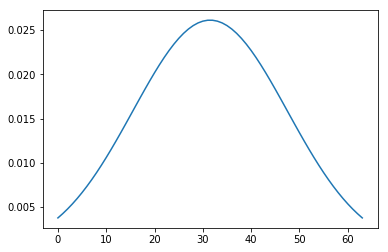

In [66]:
def gaussian_pdf(num_bit, mu, sigma):
    '''get gaussian distribution function'''
    x = np.arange(2**num_bit)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

num_bit = 6
pg = gaussian_pdf(num_bit, mu=2**5-0.5, sigma=2**4)
plt.plot(pg)
plt.show()

# Build Circuits
## Building Blocks
Define matrix representations of operations using scipy sparse matrices.
They are grouped to become a layer in a circuit, this layer can be `ArbitraryRotation` or `CNOTEntangler`.
Which are used as our basic building blocks of our `Born Machines`.

In [43]:
######  Pauli Matrices  ########
I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

p0 = (sz + I2) / 2
p1 = (-sz + I2) / 2

# single bit rotation matrices
def _ri(si, theta):
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return _ri(sz, t3).dot(_ri(sx, t2)).dot(_ri(sz, t1))

# multiple bit construction
def CNOT(ibit, jbit, n):
    '''
    CNOT gate
    
    Args:
        ibit (int): control bit.
        jbit (int): controled bit.
        n (int): total number of qubits.
    '''
    res = _([p0, I2], [ibit, jbit], n)
    res = res + _([p1, sx], [ibit, jbit], n)
    return res

def _(ops, locs, n):
    '''
    Compile operators into specific Hilbert space.

    notice the big end are high loc bits!

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return _wrap_identity([ops[i] for i in order], np.diff(locs) - 1)


def _wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res


def initial_wf(num_bit):
    '''initial wave function |00...0>.'''
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

In [44]:
class ArbitraryRotation(object):
    '''Arbitrary rotation gate'''
    def __init__(self, num_bit):
        self.num_bit = num_bit
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [_([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res

class CNOTEntangler(object):
    '''CNOT Entangler Gate.'''
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

# Circuit
A circuit is consist of queued layers, here this data structure is `BlockQueue`. A `BlockQueue` uses `theta_last` and `memo` attributes to cache sparse operators, this will accelerate simulation significantly.

In [57]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.
    
    Attributes:
        theta_last (1darray): the cached circuit parameters.
        memo (list): cached sparse matrices for layers.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        '''
        Apply operations on vector basis: qureg.
        
        Args:
            qureg (1darray): vector basis.
            theta_list (1darray): circuit parameters:
        '''
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        np.testing.assert_(len(theta_list)==0)
        
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrix update method.
    
    Args:
        layer (ArbitraryRotation): rotatio layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]

    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    
    new = old[:]
    new[isite] = _(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new

In [58]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs.'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_demo_circuit(num_bit, depth, pairs):
    '''Get the circuit used for demo'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [60]:
# let's see how this circuit look like
depth = 6
pairs = get_nn_pairs(num_bit)
circuit = get_demo_circuit(num_bit, depth, pairs)
print(circuit)

[<__main__.ArbitraryRotation object at 0x1550c94be400>, <__main__.CNOTEntangler object at 0x1550c94beeb8>, <__main__.ArbitraryRotation object at 0x1550ce353780>, <__main__.CNOTEntangler object at 0x1550ce353208>, <__main__.ArbitraryRotation object at 0x1550ce353fd0>, <__main__.CNOTEntangler object at 0x1550ce353828>, <__main__.ArbitraryRotation object at 0x1550ce353c50>, <__main__.CNOTEntangler object at 0x1550ce353ac8>, <__main__.ArbitraryRotation object at 0x1550ce353ba8>, <__main__.CNOTEntangler object at 0x1550ce353f60>, <__main__.ArbitraryRotation object at 0x1550ce353e48>, <__main__.CNOTEntangler object at 0x1550ce353b00>, <__main__.ArbitraryRotation object at 0x1550ce353908>]


In [63]:
# lets see how this circuit works
# some random operation, like rotating the first bit along x axis by pi/2.
theta_list = np.zeros(circuit.num_param)
theta_list[1] = np.pi/2.

wf = initial_wf(num_bit)
circuit(wf, theta_list)

print(wf)

[0.70710678-0.70710678j 0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.     

# MMD Loss Function
As a reminder
\begin{align}
    \mathcal{L} =&  \left\|\sum_{x} p_\theta(x) \phi(x)- \sum_{x} \pi(x) \phi(x)  \right\|^2 \\
    =&\langle K(x,y)\rangle_{x\sim p_\theta, y\sim p_\theta}-2\langle K(x,y)\rangle_{x\sim p_\theta,y\sim \pi}+\langle K(x, y)\rangle_{x\sim \pi,y\sim \pi}
\end{align}


In [50]:
class RBFMMD2(object):
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float, loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K).dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

# Build The Gradient training framework for Born Machine
The gradient of MMD loss is
\begin{eqnarray}
        \frac{\partial \mathcal{L}}{\partial \theta_l^i} &=&\langle{K(x,y)}\rangle_{x\sim p_{\theta^+}, y\sim p_\theta}-\langle {K(x,y)}\rangle_{x\sim p_{\theta^-},y\sim p_\theta}\\
        &-&\langle K(x,y)\rangle_{x\sim p_{\theta^+},y\sim \pi}+\langle {K(x,y)}\rangle_{x\sim p_{\theta^-},y\sim \pi}.
\end{eqnarray}

In [65]:
class BornMachine(object):
    '''
    Quantum Circuit Born Machine framework,

    Args:
        circuit (BlockQueue): the circuit architechture.
        mmd (RBFMMD2): maximum mean discrepancy.
        p_data (1darray): data probability distribution in computation basis.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        '''defined by the number of entanglers'''
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''get probability distribution function'''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2
        # introducing sampling error
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl), False)
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self.pdf(theta_list)
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x from probability.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim, packbits):
    '''
    emperical probability from data.
    '''
    if packbits:
        dataset = packnbits(dataset).ravel()
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

In [68]:
hndim = 2**num_bit
# mmd loss
mmd = RBFMMD2(sigma_list=[0.25,0.5,1,2,4], basis=np.arange(2**num_bit))

# Born Machine
bm = BornMachine(circuit, mmd, pg, batch_size=None)  # exact version

In [72]:
# when exact match, MMD loss should be 0
print('Exact Match -> MMD(p_Gaussian, p_Gaussian) = %.4f'%mmd(pg, pg))

theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
print('MMD loss for Initial Circuit = %.4f'%bm.mmd_loss(theta_list))

Exact Match -> MMD(p_Gaussian, p_Gaussian) = 0.0000
MMD loss for Initial Circuit = 0.1037


In [73]:
# gradient test
# these two gradients should match.
g1 = bm.gradient(theta_list)
print(g1)
g2 = bm.gradient_numerical(theta_list)
print(g2)

[ 3.07402573e-02  2.16420532e-02  1.29570731e-02 -1.68622254e-02
  5.06023437e-02  1.13935583e-02 -1.67315858e-02  9.51530525e-03
  4.70131582e-02  2.38483354e-02 -1.58803447e-02 -8.01983745e-05
  2.29841097e-02 -4.44106451e-03  1.88718875e-02  2.35138201e-02
  2.12969558e-02 -1.60441222e-02 -4.04867812e-02  3.91953757e-03
  1.69625780e-02  1.15425357e-02  7.86997236e-03  3.20237659e-02
 -8.72885952e-03 -3.09984218e-02 -9.36430380e-03  3.08977248e-02
  1.43946830e-02 -8.45831132e-03 -1.43979639e-02  2.59139608e-02
  8.44303062e-03 -3.99443790e-02  3.32963106e-02  2.43485670e-02
  7.26611529e-03 -1.87280813e-03  4.69034201e-02 -8.50573676e-03
 -2.66194303e-02 -8.99482503e-03 -6.60517345e-03 -2.38913897e-02
 -1.00917726e-02  1.84739086e-02 -1.94733847e-03  1.61604325e-03
 -6.97631886e-05 -1.30489331e-02 -6.01068742e-03 -7.81579054e-03
 -7.10112503e-03 -1.05343958e-02  5.13962529e-03 -5.24017711e-02
 -5.97847431e-03  6.68686587e-03  5.80163259e-03 -1.44187972e-03
 -1.26103683e-02 -3.31892

# Training
In this basic introduction, I prepaired classical training method like `Adam` and methods supported by scipy, like `L-BFGS-B`.

In [74]:
  def train(bm, theta_list, method, max_iter=1000, popsize=50, step_rate=0.1):
    '''train a Born Machine.'''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))
        
    theta_list = np.array(theta_list)
    if method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

step = 1, loss = 0.06170321738716275
step = 2, loss = 0.026771172131049542
step = 3, loss = 0.016683816889194198
step = 4, loss = 0.011789794203524733
step = 5, loss = 0.008743461125872452
step = 6, loss = 0.0059787761747224
step = 7, loss = 0.0042678787736000635
step = 8, loss = 0.0036479069916885393
step = 9, loss = 0.003048964351589451
step = 10, loss = 0.0025146280080125885
step = 11, loss = 0.0018863571646037932
step = 12, loss = 0.0016833894136265718
step = 13, loss = 0.0011946102927922332
step = 14, loss = 0.0011024895365303587
step = 15, loss = 0.000896647615215215
step = 16, loss = 0.0007679541937061265
step = 17, loss = 0.0006264811804289117
step = 18, loss = 0.0004609782262516271
step = 19, loss = 0.00041034237583255915
step = 20, loss = 0.00036419990746218455
step = 21, loss = 0.0003100677097027701


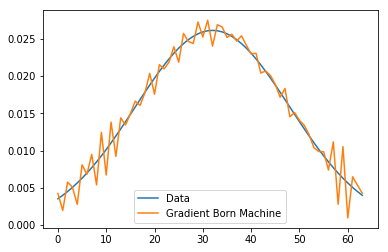

In [77]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=20)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()